# Simulation: With perfect controller

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

In [2]:
controller = True
Kp = 1e3
explicit_Euler = True
imposed_time_step = False
Δt = 3600    # s, imposed time step   

In [3]:
# MODEL
# =====
# Thermal circuits
TC = dm4bem.file2TC('TC.csv', name='', auto_number=False)

# by default TC['G']['q11'] = 0 # Kp -> 0, no controller (free-floating
if controller:
    TC['G']['q11'] = Kp     # Kp -> ∞, almost perfect controller

# State-space
[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)
# dm4bem.print_TC(TC)

In [4]:
λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
dtmax = 2 * min(-1. / λ)    # max time step for Euler explicit stability
dt = dm4bem.round_time(dtmax)

if imposed_time_step:
    dt = Δt

dm4bem.print_rounded_time('dt', dt)

dt = 50 s


## Input data set

In [5]:
# INPUT DATA SET
# ==============
input_data_set = pd.read_csv('input_data_set.csv',
                             index_col=0,
                             parse_dates=True)
#input_data_set

In [6]:
input_data_set = input_data_set.resample(
    str(dt) + 'S').interpolate(method='linear')
#input_data_set.head()

## Input vector in time

In [7]:
# Input vector in time from input_data_set
u = dm4bem.inputs_in_time(us, input_data_set)
#u.head()

## Initial conditions

In [8]:
# Initial conditions
θ0 = 20                     # °C, initial temperatures
θ = pd.DataFrame(index=u.index)
θ[As.columns] = θ0          # fill θ with initial valeus θ0

## Time integration

In [9]:
I = np.eye(As.shape[0])     # identity matrix

if explicit_Euler:
    for k in range(u.shape[0] - 1):
        θ.iloc[k + 1] = (I + dt * As) @ θ.iloc[k] + dt * Bs @ u.iloc[k]
else:
    for k in range(u.shape[0] - 1):
        θ.iloc[k + 1] = np.linalg.inv(
            I - dt * As) @ (θ.iloc[k] + dt * Bs @ u.iloc[k])

## Outputs

In [10]:
# outputs
y = (Cs @ θ.T + Ds @  u.T).T

In [11]:
Kp = TC['G']['q11']     # controller gain
S = 9                   # m², surface area of the toy house
q_HVAC = Kp * (u['q11'] - y['θ6']) / S  # W/m²
y['θ6']

2000-02-01 12:00:00+01:00    20.000000
2000-02-01 12:00:50+01:00    19.923765
2000-02-01 12:01:40+01:00    19.971095
2000-02-01 12:02:30+01:00    19.927115
2000-02-01 12:03:20+01:00    19.950813
                               ...    
2000-02-07 17:56:40+01:00    18.918714
2000-02-07 17:57:30+01:00    18.917630
2000-02-07 17:58:20+01:00    18.916549
2000-02-07 17:59:10+01:00    18.915469
2000-02-07 18:00:00+01:00    18.914392
Freq: 50S, Name: θ6, Length: 10801, dtype: float64

## Plots

In [12]:
data = pd.DataFrame({'To': input_data_set['To'],
                     'θi': y['θ6'],
                     'Etot': input_data_set['Etot'],
                     'q_HVAC': q_HVAC})

### Plots using Pandas

In [13]:
#fig, axs = plt.subplots(2, 1)
#data[['To', 'θi']].plot(ax=axs[0],
                        #xticks=[],
                        #ylabel='Temperature, $θ$ / [°C]')

#axs[0].legend(['$θ_{outdoor}$', '$θ_{indoor}$'],
              #"loc='upper right')

#data[['Etot', 'q_HVAC']].plot(ax=axs[1],
                              #ylabel='Heat rate, $q$ / [W/m²]')
#axs[1].set(xlabel='Time')
#axs[1].legend(['$E_{total}$', '$q_{HVAC}$'],
              #loc='upper right')
#plt.show();

> Figure 1. Simulation in free-running with weather data using Euler explicit method of integration. a) Indoor and outdoor temperatures. b) Solar and HVAC heat flow rates.

### Plots using matplotlib

Alternativelly, we may use `matplotlib`.

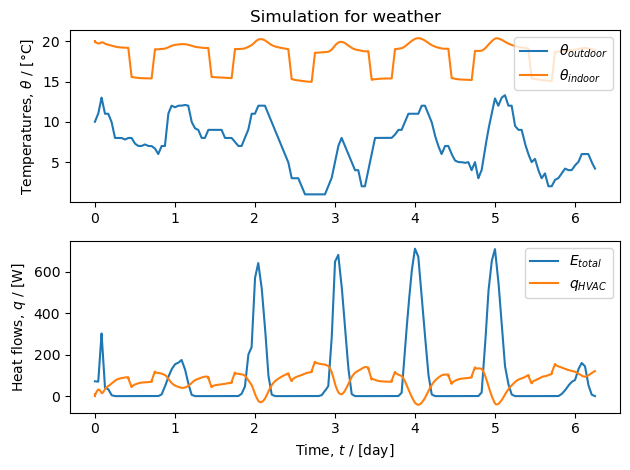

In [14]:
t = dt * np.arange(data.shape[0])   # time vector

fig, axs = plt.subplots(2, 1)
# plot outdoor and indoor temperature
axs[0].plot(t / 3600 / 24, data['To'], label='$θ_{outdoor}$')
axs[0].plot(t / 3600 / 24, y.values, label='$θ_{indoor}$')
axs[0].set(ylabel='Temperatures, $θ$ / [°C]',
           title='Simulation for weather')
axs[0].legend(loc='upper right')

# plot total solar radiation and HVAC heat flow
axs[1].plot(t / 3600 / 24, data['Etot'], label='$E_{total}$')
axs[1].plot(t / 3600 / 24, q_HVAC, label='$q_{HVAC}$')
axs[1].set(xlabel='Time, $t$ / [day]',
           ylabel='Heat flows, $q$ / [W]')
axs[1].legend(loc='upper right')

fig.tight_layout()

> Figure 2. Simulation in free-running with weather data using Euler explicit method of integration. a) Indoor and outdoor temperatures. b) Solar and HVAC heat flow rates.

## Discussion

This version of the code contains a perfect heat controller, which means, as we can see on the first graph above, the inside temperature is controlled. The inside temperatures is subject to a periodical control on a daily basis. Although the outdoor temperature is changing, the indisde temperature is constant dur to the heat inflow represented on the second graph. Because of the smulation dates taken during winter, the heat flow Qhvac is positiv. It's also noticable that an increasing solar radiation causes a lower necessary heat inflow.   

For the following modification, we will implement the opposite simulation, without controller heat, in order to state about the influence of the outdoor temperature on the inside temperature. 
